#  AGN fraction vs Ne Spectral Lines Ratios

Import of the libraries

In [1]:
from astropy.table import Table, Column, table, vstack, join
from pathlib import Path

import numpy as np
import astropy.units as u

from matplotlib import pyplot as plt

Reading the different paths where the results has been saved

In [2]:
path_raw = '../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

In [3]:
date_sample = 'Sep_02_2022'
Ne_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

We remove the galaxies without energy balance that was removed in the CIGALE's phot files (Notebook 04).

In [4]:
CIG_BadGalaxies = Table.read('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii')
for id in CIG_BadGalaxies['id']:
    Ne_Sy.remove_rows(np.where(Ne_Sy['Main_Id'] == id)[0])

Now we classify the tables according to their Ne line information

In [5]:
NeV_NeII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeV']])

NeV_NeIII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeIII|NeV']])

NeIII_NeII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII']])

print('Total objects with [NeV] and [NeII] info:',len(NeV_NeII_Sy))
print('Total objects with [NeV] and [NeIII] info:',len(NeV_NeIII_Sy))
print('Total objects with [NeIII] and [NeII] info:',len(NeIII_NeII_Sy))

Total objects with [NeV] and [NeII] info: 162
Total objects with [NeV] and [NeIII] info: 156
Total objects with [NeIII] and [NeII] info: 191


## Extracting the Neon lines flux values from NED phot tables

In [6]:
def Neon_info(NED_table, Freq):
    
    '''
    This function create a new table from the Phot NED table
    but with the flux of [NeII] and [NeV]
    '''
    
    NED_table.remove_rows(np.where(NED_table['Flux_Density'].mask)[0])
    NED_table.remove_rows(np.where(NED_table['NED_Units'] == 'Jy')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] line (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.4 (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.37 (IRS)')[0])
    
    Ne_idx = [np.where(NED_table['Frequency'] == freq)[0] for freq in Freq]
    #print(Ne_idx)
    #print(len(Ne_idx))
    i = []
    Ne_table = Table()
    for idx in range(len(Freq)):
        Ne_table = vstack([Ne_table,NED_table[Ne_idx[idx]]])
    
    for ind in range(len(Ne_table)):
        i.append(ind)
    
    Ne_table['idx'] = i
    Ne_inf = Ne_table['idx','Observed_Passband','Flux_Density','NED_Uncertainty','NED_Units','Refcode']
    obs_passb = np.unique(Ne_inf['Observed_Passband'])
    #print(obs_passb)
    return Ne_inf

## Calculating the ratios: [NeV]/[NeII], [NeV]/[NeIII] and [NeIII]/[NeII]

In [7]:
def Ne_ratios(Ne_info,Nel1,Nel2,Nel1a,Nel2a,not_same_bib):
    
    '''
    This function is for compute the ratio between two Neon
    emission lines (line1/line2) that have the same bibcode
    '''
    #Extract the number value of the NED_Uncertainty
    for u in range(len(Ne_info)):
        #print(u,Ne_info['NED_Uncertainty'][u])
        if Ne_info['NED_Uncertainty'][u] != '':
            Ne_info['NED_Uncertainty'][u] = float(Ne_info['NED_Uncertainty'][u].split('+/-')[-1])
    
    bibcod, count = np.unique(Ne_info['Refcode'], return_counts=True) #Extract the bibcodes
    print('No. of [Ne] data',len(Ne_info))
    flag = 0 #Flag to detect when there is not info of the two Ne lines for the same bibcode
    
    #Print the lines passband names
    #print('Neon line 1:',Nel1,'& Neon line 2:',Nel2)
    #print('Others filter names for Neon line1:',Nel1a,'& Neon line 2:',Nel2a)
    
    Ne_ratio = []
    Ne_ratio_err = []
    Ne_filter = []
    refcode = []
    #print(Ne_info) #Print the Ne Info of each galaxy
    
    for idx,bib in enumerate(bibcod):
        i = np.where(Ne_info['Refcode'] == bib)[0]
        #The ratio [Ne]line1/[Ne]line2 is calculated for only the bibcodes that have both flux data
        if len(i)>=2:
            flag += 1
            #print(len(i))
            Neline1_i = 'nan'
            Neline2_i = 'nan'
            for j,ind in enumerate(i):
                if Nel1 in Ne_info['Observed_Passband'][ind] or Nel1a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel1)
                    Neline1_i = ind
                elif Nel2 in Ne_info['Observed_Passband'][ind] or Nel2a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel2)
                    Neline2_i = ind
            if Neline1_i != 'nan' and Neline2_i != 'nan':
                Neline1 = Ne_info['Flux_Density'][Neline1_i]
                Neline1_err = Ne_info['NED_Uncertainty'][Neline1_i]
                Neline2 = Ne_info['Flux_Density'][Neline2_i]
                Neline2_err = Ne_info['NED_Uncertainty'][Neline2_i]
                Neline1_Neline2 = Neline1/Neline2
                Ne_ratio.append(Neline1_Neline2)
                Ne_filter.append(Ne_info['Observed_Passband'][Neline1_i])
                Ne_filter.append(Ne_info['Observed_Passband'][Neline2_i])
                refcode.append(bib)
                #print('For bibcode',',',bib,Nel1,'index is:',Neline1_i,'and',Nel2,'index is:',Neline2_i)
                #print('For bibcode', bib,Nel1,'/',Nel2,'ratio is:',Neline1_Neline2)
                if Neline1_err != '' or Neline2_err != '':
                    Neline1_Neline2_err = np.absolute(Neline1_Neline2)*\
                    np.sqrt((Neline1_err/Neline1)**2+(Neline2_err/Neline2)**2)
                    #Neline1_Neline2_err = Neline1_err/Neline2_err
                else:
                    Neline1_Neline2_err = np.nan #Se usa np.nan para poder hacer operaciones mat con este
                Ne_ratio_err.append(Neline1_Neline2_err)
            #In some cases there is two data for one bibcode but for the same spectral line
            elif (Neline1_i == 'nan' and Neline2_i != 'nan') and len(Ne_info)==2:
                flag = 0
    if flag<1:
        not_same_bib += 1
        #for r in range(len(NeV_NeII_inf)): refcode.append(NeV_NeII_inf['Refcode'][r])
         
    return Ne_ratio, Ne_ratio_err, Ne_filter, refcode, not_same_bib

In the galaxies where there are more than one data of [NeII] or [NeV], we remove the rows if per bibcode there is data for only one the them. The idea is to have both [NeII] and [NeV] data per bibcode:

## [NeV]/[NeII]

In [8]:
Nefilter = []
Refcode = []
NeV_NeII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err'),
                dtype=('O','f8','f8','O','f8','f8','f8'))
NeV_NeII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeV_NeII_Sy)):
    NED_phot = Table()
    obj = NeV_NeII_Sy['Main_Id'][id]
    ra = NeV_NeII_Sy['RA'][id]
    dec = NeV_NeII_Sy['DEC'][id]
    otype = NeV_NeII_Sy['otype_txt'][id]
    z = NeV_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    NeV_NeII_Freq = [20900000000000.0,21000000000000.0,23400000000000.0]
    NeV_NeII_inf = Neon_info(NED_phot, NeV_NeII_Freq)
    
    NeV_NeII_ratios,NeV_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeII_inf,'[Ne V]','[Ne II]','nan','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeII_ratios)
    std_Ne_ratios = np.std(NeV_NeII_ratios)
    err = np.sqrt(np.sum(np.array(NeV_NeII_ratios_err)**2))/len(NeV_NeII_ratios_err)
    NeV_NeII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeV_NeII.add_row(vals=NeV_NeII_row)
    
    for b,ratio in enumerate(NeV_NeII_ratios):
        NeV_NeII_bib_row = [obj,ra,dec,otype,z,ratio,NeV_NeII_ratios_err[b],refcode[b]]
        NeV_NeII_bib.add_row(vals=NeV_NeII_bib_row)

    print(NeV_NeII_ratios)
    print(NeV_NeII_ratios_err)
    print(refcode)
    print('\n')
    
print('Number of galaxies with diferent bibcode for [NeV] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeII] fluxes:',\
      np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeII] information
Ne_filters1, countspb1 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters1)): print(Ne_filters1[pb])
    
refcodes1, countsrc1 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes1)): print(refcodes1[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[4.125]
[1.3524428130239001]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.3548780487804878, 0.45098039215686275, 0.3548780487804878]
[0.022645479318087677, 0.03208429446652159, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.16402877697841728, 0.16402877697841728]
[0.0343865128420725, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.4275184275184275]
[0.030864694616613318]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[0.3617021276595745, 0.3617021276595745]
[0.03194737630815746, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] data 2
[0.7553191489361702]
[nan]
['2010ApJ...725.2270P']


6
Galaxy:  LEDA   89511
P

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 11
[1.3841961852861036, 1.0060240963855422, 1.4404761904761905, 1.0060240963855422]
[nan, 0.1524210995249283, 0.1855737551079056, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


35
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2577833125778331]
[0.022601371918987024]
['2010ApJ...716.1151W']


36
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 3
[1.7878787878787878]
[0.279439361062646]
['2007ApJ...660..117C']


37
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[1.4]
[nan]
['2011ApJS..195...17W']


38
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 14
[0.07246376811594203, 0.06, 0.08020833333333334, 0.04670391061452514]
[nan, nan, 0.005329067600533414, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..193...18W']


39
Galaxy:  IRAS F08216+3009
Phot table lenght: 110
No. of [Ne] data 2
[1.0873493975903614]
[0.10712386204

No. of [Ne] data 6
[1.0714285714285714, 0.9158751696065129]
[0.10468512514634282, nan]
['2007ApJ...671..124D', '2011ApJS..195...17W']


81
Galaxy:  NGC  1667
Phot table lenght: 169
No. of [Ne] data 6
[0.1306930693069307, 0.1306930693069307]
[0.02603362899730117, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


82
Galaxy:  NGC  1320
Phot table lenght: 128
No. of [Ne] data 6
[0.8888888888888888, 1.116910229645094, 0.8888888888888888]
[0.14866166146657153, 0.0556451153047063, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


83
Galaxy:  Mrk 1073
Phot table lenght: 133
No. of [Ne] data 3
[0.5520282186948854]
[0.012831993633831681]
['2011ApJ...740...94D']


84
Galaxy:  NGC  5643
Phot table lenght: 174
No. of [Ne] data 10
[0.630272952853598, 0.5301724137931034, 0.6578947368421053, 0.5301724137931034]
[nan, 0.04633986967478526, nan, nan]
['2009ApJ...690.1105K', '2009MNRAS.398.1165G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


85
Galaxy:  NGC  2273
Phot tab

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[1.1875]
[nan]
['2010ApJ...725.2270P']


115
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[0.8571428571428571, 0.3715151515151515, 0.5714285714285714, 0.3715151515151515]
[0.09407698425809068, 0.025313014737480592, 0.13466029660005585, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


116
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 2
[4.562118126272912]
[nan]
['2009ApJ...690.1105K']


117
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 7
[0.8518518518518519, 0.796875, 1.1875]
[0.18714943898875788, 0.07259959401235218, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']


118
Galaxy:  NGC  5990
Phot table lenght: 112
No. of [Ne] data 2
[]
[]
[]


119
Galaxy:  Mrk    3
Phot table lenght: 278
No. of [Ne] data 10
[1.2674418604651163, 0.646, 0.6459183673469387, 1.2674418604651163]
[0.22527036734403713, nan, 0.010186545354847087, nan]
['2007ApJ.

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

Phot table lenght: 425
No. of [Ne] data 16
[1.0588235294117647, 0.6726190476190477, 0.5047169811320755, 0.5177664974619289, 0.6470588235294118, 0.6242774566473989, 0.5047169811320755]
[0.171341431185328, 0.03200680723936727, 0.018083975533853824, 0.04090642225496949, nan, 0.028650487974464286, nan]
['2007ApJ...671..124D', '2009MNRAS.398.1165G', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


121
Galaxy:  LEDA   70560
Phot table lenght: 78
No. of [Ne] data 2
[0.6222910216718266]
[0.09525666098581355]
['2011ApJ...740...94D']


122
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
[0.5774378585086042]
[0.03804586236067253]
['2011ApJ...740...94D']


123
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[0.3821292775665399]
[0.044754725451438174]
['2010ApJ...716.1151W']


124
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 3
[2.0861423220973783]
[0.252525703158059]
['2010ApJ...716.1151W']


1

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[3.1223021582733814]
[nan]
['2006ApJ...649...79S']


155
Galaxy:  2MASX J14510879+2709272
Phot table lenght: 99
No. of [Ne] data 2
[5.266272189349112]
[nan]
['2006ApJ...649...79S']


156
Galaxy:  MCG+13-07-002
Phot table lenght: 100
No. of [Ne] data 2
[0.7883211678832117]
[nan]
['2006ApJ...649...79S']


157
Galaxy:  LEDA    1790
Phot table lenght: 161
No. of [Ne] data 4
[2.0655021834061134]
[nan]
['2006ApJ...649...79S']


158
Galaxy:  Ton  1565
Phot table lenght: 120
No. of [Ne] data 3
[0.5305719921104537]
[nan]
['2006ApJ...649...79S']


159
Galaxy:  2E  2389
Phot table lenght: 180
No. of [Ne] data 2
[1.1556064073226544]
[0.17151303566833198]
['2011ApJ...740...94D']


160
Galaxy:  ICRF J130533.0-103319
Phot table lenght: 126
No. of [Ne] data 3
[1.3679775280898876]
[nan]
['2006ApJ...649...79S']


161
Galaxy:  LBQS 1244+0238
Phot table lenght: 156
No. of [Ne] data 2
[0.5636942675159236]
[nan]
['2006ApJ...649...79S']


Number of galaxies with diferent bibcode for [NeV] 

In [9]:
#Remove the galaxies where there was not info with same bibcode
NeV_NeII.remove_rows(np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])
NeV_NeII_bib.remove_rows(np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

In [10]:
print('Final number of galaxies with [Ne V] and [Ne II] info: ', len(NeV_NeII))

Final number of galaxies with [Ne V] and [Ne II] info:  158


## [NeV]/[NeIII]

In [11]:
Nefilter = []
Refcode = []
NeV_NeIII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeIII]','[NeV]/[NeIII]_err'),
                 dtype=('O','f8','f8','O','f8','f8','f8'))
NeV_NeIII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeIII]',\
                             '[NeV]/[NeIII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeV_NeIII_Sy)):
    NED_phot = Table()
    obj = NeV_NeIII_Sy['Main_Id'][id]
    ra = NeV_NeIII_Sy['RA'][id]
    dec = NeV_NeIII_Sy['DEC'][id]
    otype = NeV_NeIII_Sy['otype_txt'][id]
    z = NeV_NeIII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeV_NeIII_Freq = [20900000000000.0,21000000000000.0,19200000000000.0,19300000000000.0]
    NeV_NeIII_inf = Neon_info(NED_phot, NeV_NeIII_Freq)
    
    NeV_NeIII_ratios,NeV_NeIII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeIII_inf,'[Ne V]','[Ne III]','nan','[NeIII]',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeIII_ratios)
    std_Ne_ratios = np.std(NeV_NeIII_ratios)
    err = np.sqrt(np.sum(np.array(NeV_NeIII_ratios_err)**2))/len(NeV_NeIII_ratios_err)
    NeV_NeIII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeV_NeIII.add_row(vals=NeV_NeIII_row)
    
    for b,ratio in enumerate(NeV_NeIII_ratios):
        NeV_NeIII_bib_row = [obj,ra,dec,otype,z,ratio,NeV_NeIII_ratios_err[b],refcode[b]]
        NeV_NeIII_bib.add_row(vals=NeV_NeIII_bib_row)
    
    print(NeV_NeIII_ratios)
    print(NeV_NeIII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeV] and [NeIII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeIII] fluxes:',\
      np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeIII] information
Ne_filters2, countspb2 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters2)): print(Ne_filters2[pb])
    
refcodes2, countsrc2 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes2)): print(refcodes2[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[0.4024390243902439, 0.6911764705882353]
[0.09201936826462354, 0.100914932142928]
['2006ApJ...647..161O', '2010ApJ...709.1257T']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.2852941176470588, 0.33495145631067963, 0.2852941176470588]
[0.017961061968501214, 0.021688727467788264, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.32294617563739375, 0.32294617563739375]
[0.06916357647608341, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.43283582089552236]
[0.03462284221323469]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 4
[0.3624733475479744, 0.3624733475479744]
[0.029546122420736395, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] data 2

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars
 

No. of [Ne] data 11
[0.8488372093023255, 0.7514792899408284, 0.8520408163265306, 0.9138972809667674, 0.8520408163265306]
[nan, nan, 0.11920855509748761, 0.1235123298283933, nan]
['2007ApJ...655L..73G', '2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


35
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2320627802690583]
[0.02247090765432689]
['2010ApJ...716.1151W']


36
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 4
[0.75, 0.7283950617283951]
[nan, 0.12011916377404842]
['2007ApJ...655L..73G', '2007ApJ...660..117C']


37
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[0.5907801418439717]
[nan]
['2011ApJS..195...17W']


38
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 13
[0.43103448275862066, 0.3333333333333333, 0.4301675977653631, 0.24807121661721068]
[nan, nan, 0.029350715220541432, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..193...18

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars
 

No. of [Ne] data 2
[0.48600883652430044]
[0.033068698253822096]
['2010ApJ...716.1151W']


59
Galaxy:  Mrk  618
Phot table lenght: 127
No. of [Ne] data 4
[0.7230483271375465, 0.7230483271375465]
[0.10616729760599929, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


60
Galaxy:  Mrk  609
Phot table lenght: 147
No. of [Ne] data 5
[1.0, 0.6825396825396826]
[0.24845199749997662, 0.08139731245843908]
['2007ApJ...671..124D', '2011ApJ...740...94D']


61
Galaxy:  NGC  3079
Phot table lenght: 331
No. of [Ne] data 9
[0.043859649122807015, 0.03791666666666667, 0.05646551724137931]
[nan, nan, nan]
['2007ApJ...655L..73G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


62
Galaxy:  2C   94
Phot table lenght: 226
No. of [Ne] data 2
[0.37735849056603776]
[0.05836748377170459]
['2006ApJ...647..161O']


63
Galaxy:  NGC  5548
Phot table lenght: 420
No. of [Ne] data 15
[0.5697674418604651, 0.35714285714285715, 0.41759352881698686, 0.7427785419532325, 0.21690767519466073, 0.38508557457212717, 0.74277854

Phot table lenght: 190
No. of [Ne] data 6
[0.43658210947930576, 0.4399441340782123]
[0.02890784380195692, 0.05284629911000138]
['2010ApJ...709.1257T', '2010ApJ...716.1151W']


97
Galaxy:  IC  450
Phot table lenght: 233
No. of [Ne] data 4
[0.2553191489361702, 0.19046653144016226]
[0.02195913596312341, nan]
['2007ApJ...671..124D', '2011ApJS..195...17W']


98
Galaxy:  MCG-02-08-039
Phot table lenght: 96
No. of [Ne] data 6
[1.0, 0.6731358529111338, 0.6731358529111338]
[0.14142135623730953, 0.03779091573823343, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


99
Galaxy:  NGC  7674
Phot table lenght: 306
No. of [Ne] data 9
[0.6739130434782609, 0.6005665722379604, 0.5317919075144508, 0.6739130434782609]
[0.052429785438028974, 0.0100928468768534, 0.02256342874392695, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJ...740...94D', '2011ApJS..195...17W']


100
Galaxy:  ESO  12-21
Phot table lenght: 89
No. of [Ne] data 2
[0.4968847352024922]
[nan]
['2011ApJS

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars
 

[]
[]
[]


119
Galaxy:  Mrk    3
Phot table lenght: 278
No. of [Ne] data 10
[0.5265700483091788, 0.35494505494505496, 0.3617142857142857, 0.5265700483091788]
[0.09382298335608735, nan, 0.004851469095010472, nan]
['2007ApJ...671..124D', '2009ApJ...690.1105K', '2011ApJ...740...94D', '2011ApJS..195...17W']


120
Galaxy:  NGC  4051
Phot table lenght: 425
No. of [Ne] data 15
[0.782608695652174, 0.70625, 0.6257309941520468, 0.6219512195121951, 0.6875, 0.6666666666666666, 0.6257309941520468]
[0.11042027876378248, 0.033950935640771215, 0.024340660112324414, 0.04300354298684747, nan, 0.02686978100009198, nan]
['2007ApJ...671..124D', '2009MNRAS.398.1165G', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


121
Galaxy:  LEDA   70560
Phot table lenght: 78
No. of [Ne] data 2
[0.78515625]
[0.12324657768645862]
['2011ApJ...740...94D']


122
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
[0.6088709677419355]
[0.042319982784

In [12]:
#Remove the galaxies where there was not info with same bibcode
NeV_NeIII.remove_rows(np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])
NeV_NeIII_bib.remove_rows(np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

print('Final number of galaxies with [Ne V] and [Ne III] info: ', len(NeV_NeIII))

Final number of galaxies with [Ne V] and [Ne III] info:  153


## [NeIII]/[NeII]

In [13]:
Nefilter = []
Refcode = []
NeIII_NeII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeIII]/[NeII]','[NeIII]/[NeII]_err'),
                   dtype=('O','f8','f8','O','f8','f8','f8'))
NeIII_NeII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeIII]/[NeII]','[NeIII]/[NeII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeIII_NeII_Sy)):
    NED_phot = Table()
    obj = NeIII_NeII_Sy['Main_Id'][id]
    ra = NeIII_NeII_Sy['RA'][id]
    dec = NeIII_NeII_Sy['DEC'][id]
    otype = NeIII_NeII_Sy['otype_txt'][id]
    z = NeIII_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeIII_NeII_Freq = [19200000000000.0,19300000000000.0,23400000000000.0]
    NeIII_NeII_inf = Neon_info(NED_phot, NeIII_NeII_Freq)
    
    NeIII_NeII_ratios,NeIII_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeIII_NeII_inf,'[Ne III]','[Ne II]','[NeIII]','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
    
    avg_Ne_ratios = np.average(NeIII_NeII_ratios)
    std_Ne_ratios = np.std(NeIII_NeII_ratios)
    err = np.sqrt(np.sum(np.array(NeIII_NeII_ratios_err)**2))/len(NeIII_NeII_ratios_err)
    NeIII_NeII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeIII_NeII.add_row(vals=NeIII_NeII_row)
    
    for b,ratio in enumerate(NeIII_NeII_ratios):
        NeIII_NeII_bib_row = [obj,ra,dec,otype,z,ratio,NeIII_NeII_ratios_err[b],refcode[b]]
        NeIII_NeII_bib.add_row(vals=NeIII_NeII_bib_row)

    print(NeIII_NeII_ratios)
    print(NeIII_NeII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeIII] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeIII] and [NeII] fluxes:',\
      np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeIII] and [NeII] information
Ne_filters3, countspb3 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters3)): print(Ne_filters3[pb])

refcodes3, countsrc3 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes3)): print(refcodes3[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[10.25]
[2.7077723778043086]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 8
[1.9230769230769231, 1.2439024390243902, 1.34640522875817, 1.2439024390243902]
[0.16673376098941267, 0.03523648682068849, 0.08310665402417797, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 6
[0.75, 0.5079136690647482, 0.5079136690647482]
[0.10416666666666667, 0.03528595770676373, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 4
[1.5365853658536586, 0.9877149877149877]
[0.12675147981745505, 0.05999912237448755]
['2010ApJ...725..605S', '2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[0.997872340425532, 0.997872340425532]
[0.0601417267924671, nan]
['2010ApJ...709.1257

No. of [Ne] data 8
[1.8026315789473684, 3.4026548672566372, 1.8928571428571428, 1.4672131147540983]
[0.10863096966247514, 0.09415635654441236, nan, 0.03588758367347756]
['2010ApJ...716.1151W', '2010ApJ...725..605S', '2010ApJ...725.2270P', '2011ApJ...740...94D']


48
Galaxy:  ESO 140-43
Phot table lenght: 147
No. of [Ne] data 4
[1.219298245614035, 1.453790238836968]
[0.039512663319430645, 0.04964980038615812]
['2010ApJ...716.1151W', '2011ApJ...740...94D']


49
Galaxy:  IC 1816
Phot table lenght: 112
No. of [Ne] data 2
[1.065217391304348]
[0.10809757081977944]
['2010ApJ...716.1151W']


50
Galaxy:  ESO 417-6
Phot table lenght: 78
No. of [Ne] data 2
[1.4350282485875707]
[0.12019752309352366]
['2010ApJ...716.1151W']


51
Galaxy:  NGC   788
Phot table lenght: 136
No. of [Ne] data 4
[2.063732928679818, 2.2950819672131146]
[0.08332639672367903, nan]
['2010ApJ...716.1151W', '2010ApJ...725.2270P']


52
Galaxy:  IC 5063
Phot table lenght: 302
No. of [Ne] data 9
[2.4831460674157304, 2.613475177304

No. of [Ne] data 2
[0.5814159292035398]
[nan]
['2011ApJS..195...17W']


91
Galaxy:  3C  84
Phot table lenght: 657
No. of [Ne] data 8
[0.4264705882352941, 1.261127596439169, 0.4883720930232558, 0.48484848484848486]
[nan, 0.045562353202242306, nan, 0.014744851108487474]
['2009ApJ...690.1105K', '2010ApJ...725..605S', '2010ApJ...725.2270P', '2011ApJ...740...94D']


92
Galaxy:  ESO 445-50
Phot table lenght: 344
No. of [Ne] data 15
[2.6923076923076925, 1.9406392694063928, 2.0652173913043477, 2.162251655629139, 2.2107438016528924, 2.0652173913043477]
[0.1550363610245432, nan, 0.06495300656928663, 0.20009786303672394, 0.063226003383792, nan]
['2007ApJ...671..124D', '2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJ...740...94D', '2011ApJS..195...17W']


93
Galaxy:  Mrk  817
Phot table lenght: 200
No. of [Ne] data 7
[0.8, 1.2056892778993435, 1.195822454308094]
[0.25612496949731395, 0.28686371411600825, nan]
['2007ApJ...671..124D', '2010ApJ...716.1151W', '2011ApJS..195

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/3295515250.py:35: RuntimeWarning: invalid value encountered in double_scalars
 

No. of [Ne] data 2
[2.25]
[nan]
['2010ApJ...725.2270P']


115
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[1.2857142857142858, 0.5133333333333333, 0.6909774436090226, 0.5133333333333333]
[0.16982976507237998, 0.029066578208979052, 0.10869498925705183, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


116
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 3
[2.6476578411405294]
[nan]
['2009ApJ...690.1105K']


117
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 6
[0.8611111111111112, 0.96875, 1.125]
[0.1237839197587688, 0.058171914057969405, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']


118
Galaxy:  NGC  5990
Phot table lenght: 112
No. of [Ne] data 2
[0.28917609046849757]
[0.04089567490545785]
['2012ApJ...744....2A']


119
Galaxy:  Mrk    3
Phot table lenght: 278
No. of [Ne] data 10
[2.4069767441860463, 1.82, 2.388571428571429, 1.7857142857142858, 2.40697674

No. of [Ne] data 2
[0.6296296296296297]
[0.10036241275083867]
['2010ApJ...716.1151W']


159
Galaxy:  NGC  3998
Phot table lenght: 224
No. of [Ne] data 2
[0.6272727272727273]
[nan]
['2010ApJ...725.2270P']


160
Galaxy:  LEDA   37102
Phot table lenght: 162
No. of [Ne] data 4
[17.6875, 18.733333333333334]
[2.2188737861596026, 6.267178860077118]
['2008ApJ...673..193W', '2009ApJ...704.1159H']


161
Galaxy:  NGC    34
Phot table lenght: 231
No. of [Ne] data 6
[0.3125, 0.12226487523992323, 0.12226487523992323]
[0.03274034104343791, 0.011091486682549995, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


162
Galaxy:  M  81
Phot table lenght: 294
No. of [Ne] data 2
[0.7777777777777778]
[nan]
['2010ApJ...725.2270P']


163
Galaxy:  NGC  2639
Phot table lenght: 175
No. of [Ne] data 8
[0.5454545454545454, 0.4311557788944724, 0.550561797752809, 0.5672853828306265]
[0.1345357074057827, 0.027815299650014547, nan, 0.028604035460535207]
['2007ApJ...671..124D', '2010ApJ...709.12

In [14]:
#Remove the galaxies where there was not info with same bibcode
NeIII_NeII.remove_rows(np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])
NeIII_NeII_bib.remove_rows(np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

print('Final number of galaxies with [Ne III] and [Ne II] info: ', len(NeIII_NeII))

Final number of galaxies with [Ne III] and [Ne II] info:  190


## [NeII]/[NeV]

In [15]:
Nefilter = []
Refcode = []
NeII_NeV = Table(names=('Main_id','RA','DEC','otype','redshift','[NeII]/[NeV]','[NeII]/[NeV]_err'),
                dtype=('O','f8','f8','O','f8','f8','f8'))
NeII_NeV_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeII]/[NeV]','[NeII]/[NeV]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeV_NeII_Sy)):
    NED_phot = Table()
    obj = NeV_NeII_Sy['Main_Id'][id]
    ra = NeV_NeII_Sy['RA'][id]
    dec = NeV_NeII_Sy['DEC'][id]
    otype = NeV_NeII_Sy['otype_txt'][id]
    z = NeV_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    NeII_NeV_Freq = [20900000000000.0,21000000000000.0,23400000000000.0]
    NeII_NeV_inf = Neon_info(NED_phot, NeII_NeV_Freq)
    
    NeII_NeV_ratios,NeII_NeV_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeII_NeV_inf,'[Ne II]','[Ne V]','nan','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeII_NeV_ratios)
    std_Ne_ratios = np.std(NeII_NeV_ratios)
    err = np.sqrt(np.sum(np.array(NeII_NeV_ratios_err)**2))/len(NeII_NeV_ratios_err)
    NeII_NeV_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeII_NeV.add_row(vals=NeII_NeV_row)
    
    for b,ratio in enumerate(NeII_NeV_ratios):
        NeII_NeV_bib_row = [obj,ra,dec,otype,z,ratio,NeII_NeV_ratios_err[b],refcode[b]]
        NeII_NeV_bib.add_row(vals=NeII_NeV_bib_row)

    print(NeII_NeV_ratios)
    print(NeII_NeV_ratios_err)
    print(refcode)
    print('\n')
    
print('Number of galaxies with diferent bibcode for [NeII] and [NeV] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeII] and [NeV] fluxes:',\
      np.where(np.isnan(NeII_NeV['[NeII]/[NeV]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeII] information
Ne_filters1, countspb1 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters1)): print(Ne_filters1[pb])
    
refcodes1, countsrc1 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes1)): print(refcodes1[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[0.24242424242424243]
[0.07948240590774068]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[2.8178694158075603, 2.217391304347826, 2.8178694158075603]
[0.17981389324030367, 0.15775283536374793, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[6.0964912280701755, 6.0964912280701755]
[1.2780505821438957, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[2.339080459770115]
[0.16886992332366824]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[2.764705882352941, 2.764705882352941]
[0.24419292133121043, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] data 2
[1.323943661971831]
[nan]
['2010ApJ...725.2270P']


6
Galaxy:  LEDA   89

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/639126384.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[3.8792270531400965]
[0.3401145423629514]
['2010ApJ...716.1151W']


36
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 3
[0.559322033898305]
[0.08742012760621128]
['2007ApJ...660..117C']


37
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[0.7142857142857143]
[nan]
['2011ApJS..195...17W']


38
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 14
[13.8, 16.666666666666668, 12.467532467532468, 21.411483253588518]
[nan, nan, 0.8283468882866577, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..193...18W']


39
Galaxy:  IRAS F08216+3009
Phot table lenght: 110
No. of [Ne] data 2
[0.9196675900277008]
[0.09060412803603857]
['2011ApJ...740...94D']


40
Galaxy:  IRAS 15091-2107
Phot table lenght: 82
No. of [Ne] data 2
[1.3561320754716981]
[nan]
['2011ApJS..195...17W']


41
Galaxy:  UGC 12282
Phot table lenght: 52
No. of [Ne] data 2
[4.16]
[0.5661468360770022]
['2010ApJ...716.1151W']


42
Galaxy:

No. of [Ne] data 3
[1.8115015974440896]
[0.042108675206921714]
['2011ApJ...740...94D']


84
Galaxy:  NGC  5643
Phot table lenght: 174
No. of [Ne] data 10
[1.5866141732283465, 1.886178861788618, 1.52, 1.886178861788618]
[nan, 0.1648619965216235, nan, nan]
['2009ApJ...690.1105K', '2009MNRAS.398.1165G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


85
Galaxy:  NGC  2273
Phot table lenght: 135
No. of [Ne] data 6
[9.029535864978904, 8.88888888888889]
[nan, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P']


86
Galaxy:  NGC  7172
Phot table lenght: 302
No. of [Ne] data 12
[3.8238702201622248, 3.235294117647059, 3.5595105672969964, 3.4831460674157304, 3.713968957871397, 3.235294117647059]
[nan, 0.2344509765308183, 0.4171297576025991, nan, 0.1694516060904128, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


87
Galaxy:  2MASX J10181928+3722419
Phot table lenght: 72
No. of [Ne] data 2
[0.52228915

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/639126384.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[0.8421052631578947]
[nan]
['2010ApJ...725.2270P']


115
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[1.1666666666666667, 2.6916802610114194, 1.75, 2.6916802610114194]
[0.12804922857351234, 0.18339640210552471, 0.41239715833767104, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


116
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 2
[0.21919642857142857]
[nan]
['2009ApJ...690.1105K']


117
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 7
[1.173913043478261, 1.2549019607843137, 0.8421052631578947]
[0.25790537055350565, 0.11432831106289677, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']


118
Galaxy:  NGC  5990
Phot table lenght: 112
No. of [Ne] data 2
[]
[]
[]


119
Galaxy:  Mrk    3
Phot table lenght: 278
No. of [Ne] data 10
[0.7889908256880734, 1.5479876160990713, 1.5481832543443919, 0.7889908256880734]
[0.14023227311476297, nan, 0.02

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/639126384.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[1.7317880794701987]
[0.11410296352848995]
['2011ApJ...740...94D']


123
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[2.616915422885572]
[0.30649138434697426]
['2010ApJ...716.1151W']


124
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 3
[0.4793536804308797]
[0.05802534368341193]
['2010ApJ...716.1151W']


125
Galaxy:  NGC  7682
Phot table lenght: 129
No. of [Ne] data 3
[2.757575757575758]
[0.2931958420338443]
['2010ApJ...716.1151W']


126
Galaxy:  7C 1821+6419
Phot table lenght: 120
No. of [Ne] data 2
[0.5413385826771654]
[0.04437032700166525]
['2011ApJ...740...94D']


127
Galaxy:  NGC  1358
Phot table lenght: 71
No. of [Ne] data 2
[1.457142857142857]
[nan]
['2010ApJ...725.2270P']


128
Galaxy:  2MASS J10514425+3539307
Phot table lenght: 97
No. of [Ne] data 2
[1.093167701863354]
[nan]
['2009ApJ...690.1105K']


129
Galaxy:  NGC  5929
Phot table lenght: 187
No. of [Ne] data 7
[5.25, 11.578947368421053, 11.578947368421053]
[1.4045128158902642

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39393/639126384.py:34: RuntimeWarning: invalid value encountered in double_scalars
  

No. of [Ne] data 2
[0.32027649769585254]
[nan]
['2006ApJ...649...79S']


155
Galaxy:  2MASX J14510879+2709272
Phot table lenght: 99
No. of [Ne] data 2
[0.1898876404494382]
[nan]
['2006ApJ...649...79S']


156
Galaxy:  MCG+13-07-002
Phot table lenght: 100
No. of [Ne] data 2
[1.2685185185185186]
[nan]
['2006ApJ...649...79S']


157
Galaxy:  LEDA    1790
Phot table lenght: 161
No. of [Ne] data 4
[0.48414376321353064]
[nan]
['2006ApJ...649...79S']


158
Galaxy:  Ton  1565
Phot table lenght: 120
No. of [Ne] data 3
[1.8847583643122676]
[nan]
['2006ApJ...649...79S']


159
Galaxy:  2E  2389
Phot table lenght: 180
No. of [Ne] data 2
[0.8653465346534653]
[0.12843318462325534]
['2011ApJ...740...94D']


160
Galaxy:  ICRF J130533.0-103319
Phot table lenght: 126
No. of [Ne] data 3
[0.731006160164271]
[nan]
['2006ApJ...649...79S']


161
Galaxy:  LBQS 1244+0238
Phot table lenght: 156
No. of [Ne] data 2
[1.7740112994350283]
[nan]
['2006ApJ...649...79S']


Number of galaxies with diferent bibcode for [NeI

In [16]:
#Remove the galaxies where there was not info with same bibcode
NeII_NeV.remove_rows(np.where(np.isnan(NeII_NeV['[NeII]/[NeV]']))[0])
NeII_NeV_bib.remove_rows(np.where(np.isnan(NeII_NeV['[NeII]/[NeV]']))[0])

print('Final number of galaxies with [Ne II] and [Ne V] info: ', len(NeII_NeV))

Final number of galaxies with [Ne II] and [Ne V] info:  158


## Joining tables with CIGALE results:

If we want to join to the different CIGALE results after the data cleaning from Notebook 5, we must to change the file name in the next cell:

- results0a90_All.fits
- results30y70_All.fits
- results_bestChi.fits
- resultsDBIC_All.fits

In [17]:
CIGresults = Table.read(path_CIGALE_out+'results0a90_All.fits', format='fits')

In [18]:
#CIGresults

In [19]:
CIGresults = CIGresults['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i',\
                        'bayes.agn.i_err','bayes.agn.disk_luminosity','bayes.agn.disk_luminosity_err',\
                        'bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.stellar.m_star',\
                        'bayes.stellar.m_star_err','best.reduced_chi_square','log.reduced_chi_square']
CIGresults['id'] = CIGresults['id'].astype(str) #Converting the dtype to string
CIGresults['id'] = CIGresults['id'].astype(object) #Converting the dtype to object
CIGresults['id'].name = 'Main_id' #Changing the column name
CIGresults

Main_id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3C 234.0,0.8034799514202404,0.05075017016454414,63.91729158454189,4.881367022531865,1.1161116813933017e+37,1.1278736022016923e+36,35.95897699663074,10.767347614953854,81806980038.3679,33820452612.22372,2.5104372093516596,0.39974936334306105
2MASS J13000535+1632148,0.8997482762713642,0.0035397704007171173,60.00022899305476,0.047852752121327925,1.860024667933385e+36,9.300123339666926e+34,0.5592751145937703,0.3523226196938686,90494096430.65376,16511046241.395515,2.9185132854550697,0.4651616746160927
NGC 262,0.8311068063268808,0.03429833704017644,60.353817806670925,2.5526644023994867,1.3593555756575799e+35,1.4921248565252054e+34,0.41262349283557975,0.08193771792751078,8817929015.912212,2335518610.9795184,2.7271950294763996,0.4357161966863162
IRAS 04385-0828,0.8377533360368383,0.06730830419243483,70.32589149419321,1.8647530604544669,1.6554325950846278e+35,1.3103526308916087e+34,0.6844996795586241,0.41201421991957277,4342492760.317619,1127492251.8120458,1.2743039230362945,0.10527302011565542
LEDA 45656,0.8472870737262286,0.011390816329853481,33.44539141414346,8.014410726190423,4.2875625379298865e+38,2.7301552943693627e+37,5.68208688272829,3.1546844345510996,32812730515.717808,29361087854.57715,2.2629677066531206,0.3546783564636013
Mrk 1239,0.8286637013421809,0.025625946890626614,50.00000000001281,1.1295948785109648e-05,6.127309456474869e+36,3.0636547282374343e+35,1.0983007559520899,0.7300468426918667,7956866580.785029,2832635717.464822,0.6785526532635565,-0.16841644699526223
LEDA 89032,0.6269860211415561,0.09686845515404878,21.910700836871282,15.92522582663009,1.6596867126895326e+37,1.2325195589416595e+37,8.847173816801806,5.4804467927366876,45642672500.50992,14259228572.45348,1.4405705818018235,0.15853454171126163
LEDA 3095998,0.1274444596594598,0.05632674800417101,48.18591064655329,27.79066687353976,5.558932924217351e+34,9.557112027433474e+34,0.7495806753401292,0.21809745566192315,6876707598.953519,1019918967.110452,0.8981715752631481,-0.04664069331884044


In [20]:
NeVNeII = join(NeV_NeII, CIGresults, join_type='left', keys='Main_id')
NeVNeII = NeVNeII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeII.remove_rows(np.where(np.isnan(NeVNeII['bayes.agn.i']))[0])
NeVNeII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,0.5128205128205128,0.0812943431354469,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,0.8188987719707819,0.024258975221072464,26.011843998959925,11.071888539354369,1.8591392566232316e+39,1.255581728634208e+38,32.99957287515418,13.005716016371974,82007440862.93582,69392222513.68936,1.442908260688541,0.15923871976759285
2,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,2.0566345877118184e+39,1.3435115805324631e+38,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
3,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,4.562118126272912,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,1.8396031516838928e+37,4.904386892756304e+36,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
4,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,1.987075928917609,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,2.230156853448609e+36,3.5161324093452546e+35,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
5,2MASX J14510879+2709272,222.78651997439997,27.15748964087,Sy1,0.06449,5.266272189349112,nan,0.899955362964844,0.0014940994387965115,7.5626569304964075,7.822212659918313,3.366525798361697e+37,1.6832628991808487e+36,0.15462531197470453,0.31682075857974806,26200318190.297752,11239826484.458948,1.2185272266241656,0.08583523745224399
6,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,1.4,nan,0.8034772342919497,0.05764760918306174,63.27370956183844,5.131987731592176,1.6393283787180736e+36,2.5574152409960315e+35,8.406223998670196,3.510156460305732,25023754285.502865,8748674592.276484,1.3187962121295964,0.12017769108441771
7,3C 234.0,150.45634473807,28.7858176354,Sy1,0.18494,4.125,1.3524428130239001,0.8034799514202404,0.05075017016454414,63.91729158454189,4.881367022531865,1.1161116813933017e+37,1.1278736022016923e+36,35.95897699663074,10.767347614953854,81806980038.3679,33820452612.22372,2.5104372093516596,0.39974936334306105
8,7C 1821+6419,275.4883876131,64.34339480891,Sy1,0.297,1.8472727272727272,0.15141003725431723,0.6915592854364581,0.11269035291407396,33.40082195370531,10.102853041982137,5.813284326139949e+39,1.527517162771796e+39,489.74909023323397,166.51602998912847,245212945616.7012,240727355723.95312,2.0802254795831856,0.3181104115163454


In [21]:
NeVNeIII = join(NeV_NeIII, CIGresults, join_type='left', keys='Main_id')
NeVNeIII = NeVNeIII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeIII.remove_rows(np.where(np.isnan(NeVNeIII['bayes.agn.i']))[0])
NeVNeIII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeIII],[NeV]/[NeIII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,0.37735849056603776,0.05836748377170459,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,0.7391975308641976,nan,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,2.0566345877118184e+39,1.3435115805324631e+38,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
2,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,1.7230769230769232,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,1.8396031516838928e+37,4.904386892756304e+36,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
3,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,0.8785714285714286,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,2.230156853448609e+36,3.5161324093452546e+35,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
4,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,0.5907801418439717,nan,0.8034772342919497,0.05764760918306174,63.27370956183844,5.131987731592176,1.6393283787180736e+36,2.5574152409960315e+35,8.406223998670196,3.510156460305732,25023754285.502865,8748674592.276484,1.3187962121295964,0.12017769108441771
5,3C 234.0,150.45634473807,28.7858176354,Sy1,0.18494,0.5468077474892397,0.06828504167318082,0.8034799514202404,0.05075017016454414,63.91729158454189,4.881367022531865,1.1161116813933017e+37,1.1278736022016923e+36,35.95897699663074,10.767347614953854,81806980038.3679,33820452612.22372,2.5104372093516596,0.39974936334306105
6,7C 1821+6419,275.4883876131,64.34339480891,Sy1,0.297,0.48846153846153845,0.02311472217491531,0.6915592854364581,0.11269035291407396,33.40082195370531,10.102853041982137,5.813284326139949e+39,1.527517162771796e+39,489.74909023323397,166.51602998912847,245212945616.7012,240727355723.95312,2.0802254795831856,0.3181104115163454
7,ESO 12-21,10.19198817425,-79.24003722924,Sy1,0.033396756044708376,0.4968847352024922,nan,0.21508369490617207,0.03860409079268917,28.656096724735818,16.950601102446953,2.0900701110798714e+37,1.3278704475332147e+37,4.828426087670747,3.564445634025986,46391431187.28613,18019007276.98409,1.8345684956900046,0.2635339312704195
8,ESO 33-2,73.99551422113,-75.54118678611,Sy2,0.018426,0.6672661870503597,0.064324440559246,0.674260181496204,0.03453170490695483,67.57567918752548,4.811022533898796,1.3248389102385516e+35,7.597474582484904e+34,0.15222372436896445,0.07587804598350163,21726336302.477417,3059569911.089977,1.4324715001714983,0.15608599019169317


In [22]:
NeIIINeII = join(NeIII_NeII, CIGresults, join_type='left', keys='Main_id')
NeIIINeII = NeIIINeII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeIIINeII.remove_rows(np.where(np.isnan(NeIIINeII['bayes.agn.i']))[0])
NeIIINeII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeIII]/[NeII],[NeIII]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,0.3215434083601286,0.03199976335108683,0.1676884426585983,0.07816057785123717,57.27044594574329,27.99390132811201,4.122521094010961e+36,5.782731031797155e+36,103.9120034706322,24.030265174755055,85948162689.7023,57012631337.310844,1.8403458401068076,0.26489944384462905
2,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,2.4545454545454546,0.2468333394786096,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,2.0566345877118184e+39,1.3435115805324631e+38,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
3,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,0.8682634730538922,nan,0.8997482762713642,0.0035397704007171173,60.00022899305476,0.047852752121327925,1.860024667933385e+36,9.300123339666926e+34,0.5592751145937703,0.3523226196938686,90494096430.65376,16511046241.395515,2.9185132854550697,0.4651616746160927
4,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,2.6476578411405294,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,1.8396031516838928e+37,4.904386892756304e+36,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
5,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,2.261712439418417,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,2.230156853448609e+36,3.5161324093452546e+35,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
6,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,2.369747899159664,nan,0.8034772342919497,0.05764760918306174,63.27370956183844,5.131987731592176,1.6393283787180736e+36,2.5574152409960315e+35,8.406223998670196,3.510156460305732,25023754285.502865,8748674592.276484,1.3187962121295964,0.12017769108441771
7,3C 234.0,150.45634473807,28.7858176354,Sy1,0.18494,10.25,2.7077723778043086,0.8034799514202404,0.05075017016454414,63.91729158454189,4.881367022531865,1.1161116813933017e+37,1.1278736022016923e+36,35.95897699663074,10.767347614953854,81806980038.3679,33820452612.22372,2.5104372093516596,0.39974936334306105
8,7C 1821+6419,275.4883876131,64.34339480891,Sy1,0.297,3.7818181818181817,0.31056886962893887,0.6915592854364581,0.11269035291407396,33.40082195370531,10.102853041982137,5.813284326139949e+39,1.527517162771796e+39,489.74909023323397,166.51602998912847,245212945616.7012,240727355723.95312,2.0802254795831856,0.3181104115163454


In [23]:
NeIINeV = join(NeII_NeV, CIGresults, join_type='left', keys='Main_id')
NeIINeV = NeIINeV.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeIINeV.remove_rows(np.where(np.isnan(NeIINeV['bayes.agn.i']))[0])
NeIINeV.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeII]/[NeV],[NeII]/[NeV]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,1.95,0.3091217397725368,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,0.8653465346534653,0.12843318462325534,0.8188987719707819,0.024258975221072464,26.011843998959925,11.071888539354369,1.8591392566232316e+39,1.255581728634208e+38,32.99957287515418,13.005716016371974,82007440862.93582,69392222513.68936,1.442908260688541,0.15923871976759285
2,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,0.559322033898305,0.08742012760621128,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,2.0566345877118184e+39,1.3435115805324631e+38,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
3,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,0.21919642857142857,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,1.8396031516838928e+37,4.904386892756304e+36,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
4,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,0.5032520325203252,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,2.230156853448609e+36,3.5161324093452546e+35,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
5,2MASX J14510879+2709272,222.78651997439997,27.15748964087,Sy1,0.06449,0.1898876404494382,nan,0.899955362964844,0.0014940994387965115,7.5626569304964075,7.822212659918313,3.366525798361697e+37,1.6832628991808487e+36,0.15462531197470453,0.31682075857974806,26200318190.297752,11239826484.458948,1.2185272266241656,0.08583523745224399
6,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,0.7142857142857143,nan,0.8034772342919497,0.05764760918306174,63.27370956183844,5.131987731592176,1.6393283787180736e+36,2.5574152409960315e+35,8.406223998670196,3.510156460305732,25023754285.502865,8748674592.276484,1.3187962121295964,0.12017769108441771
7,3C 234.0,150.45634473807,28.7858176354,Sy1,0.18494,0.24242424242424243,0.07948240590774068,0.8034799514202404,0.05075017016454414,63.91729158454189,4.881367022531865,1.1161116813933017e+37,1.1278736022016923e+36,35.95897699663074,10.767347614953854,81806980038.3679,33820452612.22372,2.5104372093516596,0.39974936334306105
8,7C 1821+6419,275.4883876131,64.34339480891,Sy1,0.297,0.5413385826771654,0.04437032700166525,0.6915592854364581,0.11269035291407396,33.40082195370531,10.102853041982137,5.813284326139949e+39,1.527517162771796e+39,489.74909023323397,166.51602998912847,245212945616.7012,240727355723.95312,2.0802254795831856,0.3181104115163454


In [24]:
NeVNeIINeIII_0 = join(NeVNeII, NeVNeIII, join_type='outer')
NeVNeIINeIII_1 = join(NeVNeIINeIII_0, NeIIINeII, join_type='outer')
Sy_Ne = join(NeVNeIINeIII_1, NeIINeV, join_type='outer')
Sy_Ne = Sy_Ne.filled(np.nan) #Fill the mask values (---) with numpy.nan

Sy_Ne = Sy_Ne['Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err',\
              '[NeV]/[NeIII]','[NeV]/[NeIII]_err','[NeIII]/[NeII]','[NeIII]/[NeII]_err',\
              '[NeII]/[NeV]','[NeII]/[NeV]_err',\
              'bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err',\
              'bayes.agn.disk_luminosity','bayes.agn.disk_luminosity_err',\
              'bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.stellar.m_star','bayes.stellar.m_star_err',\
              'best.reduced_chi_square','log.reduced_chi_square'] #reorder columns

Sy_Ne.write(path_FINAL+'Ne_ratios_-_CIGALE_results.tbl', format='ascii',overwrite=True)
Sy_Ne.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,[NeV]/[NeIII],[NeV]/[NeIII]_err,[NeIII]/[NeII],[NeIII]/[NeII]_err,[NeII]/[NeV],[NeII]/[NeV]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,,,,,,,deg,deg,W,W,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,0.5128205128205128,0.0812943431354469,0.37735849056603776,0.05836748377170459,1.358974358974359,0.08652562196640158,1.95,0.3091217397725368,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,nan,nan,nan,nan,0.3215434083601286,0.03199976335108683,nan,nan,0.1676884426585983,0.07816057785123717,57.27044594574329,27.99390132811201,4.122521094010961e+36,5.782731031797155e+36,103.9120034706322,24.030265174755055,85948162689.7023,57012631337.310844,1.8403458401068076,0.26489944384462905
2,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,nan,nan,nan,nan,0.8653465346534653,0.12843318462325534,0.8188987719707819,0.024258975221072464,26.011843998959925,11.071888539354369,1.8591392566232316e+39,1.255581728634208e+38,32.99957287515418,13.005716016371974,82007440862.93582,69392222513.68936,1.442908260688541,0.15923871976759285
3,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7391975308641976,nan,2.4545454545454546,0.2468333394786096,0.559322033898305,0.08742012760621128,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,2.0566345877118184e+39,1.3435115805324631e+38,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
4,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,nan,nan,nan,nan,0.8682634730538922,nan,nan,nan,0.8997482762713642,0.0035397704007171173,60.00022899305476,0.047852752121327925,1.860024667933385e+36,9.300123339666926e+34,0.5592751145937703,0.3523226196938686,90494096430.65376,16511046241.395515,2.9185132854550697,0.4651616746160927
5,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,4.562118126272912,nan,1.7230769230769232,nan,2.6476578411405294,nan,0.21919642857142857,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,1.8396031516838928e+37,4.904386892756304e+36,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
6,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,1.987075928917609,nan,0.8785714285714286,nan,2.261712439418417,nan,0.5032520325203252,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,2.230156853448609e+36,3.5161324093452546e+35,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
7,2MASX J14510879+2709272,222.78651997439997,27.15748964087,Sy1,0.06449,5.266272189349112,nan,nan,nan,nan,nan,0.1898876404494382,nan,0.899955362964844,0.0014940994387965115,7.5626569304964075,7.822212659918313,3.366525798361697e+37,1.6832628991808487e+36,0.15462531197470453,0.31682075857974806,26200318190.297752,11239826484.458948,1.2185272266241656,0.08583523745224399
8,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,1.4,nan,0.5907801418439717,nan,2.369747899159664,nan,0.7142857142857143,nan,0.8034772342919497,0.05764760918306174,63.27370956183844,5.131987731592176,1.6393283787180736e+36,2.5574152409960315e+35,8.406223998670196,3.510156460305732,25023754285.502865,8748674592.276484,1.3187962121295964,0.12017769108441771


In [25]:
NeVNeII_bib = join(NeV_NeII_bib, CIGresults, join_type='left', keys='Main_id')
NeVNeII_bib = NeVNeII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeII_bib.remove_rows(np.where(np.isnan(NeVNeII_bib['bayes.agn.i']))[0])
NeVNeIII_bib = join(NeV_NeIII_bib, CIGresults, join_type='left', keys='Main_id')
NeVNeIII_bib = NeVNeIII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeIII_bib.remove_rows(np.where(np.isnan(NeVNeIII_bib['bayes.agn.i']))[0])
NeIIINeII_bib = join(NeIII_NeII_bib, CIGresults, join_type='left', keys='Main_id')
NeIIINeII_bib = NeIIINeII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeIIINeII_bib.remove_rows(np.where(np.isnan(NeIIINeII_bib['bayes.agn.i']))[0])
NeVNeIINeIII_bib = join(NeVNeII_bib, NeVNeIII_bib, join_type='outer')
Sy_Ne_bib = join(NeVNeIINeIII_bib, NeIIINeII_bib, join_type='outer')
Sy_Ne_bib = Sy_Ne_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan

Sy_Ne_bib = Sy_Ne_bib['Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err',\
              '[NeV]/[NeIII]','[NeV]/[NeIII]_err','[NeIII]/[NeII]','[NeIII]/[NeII]_err',\
              'bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err',\
              'bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.stellar.m_star','bayes.stellar.m_star_err',\
              'best.reduced_chi_square','log.reduced_chi_square'] #reorder columns

Sy_Ne_bib.write(path_FINAL+'Ne_ratios_-_CIGALE_results_bib.tbl', format='ascii',overwrite=True)
Sy_Ne_bib.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,[NeV]/[NeIII],[NeV]/[NeIII]_err,[NeIII]/[NeII],[NeIII]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,,,,,deg,deg,solMass / yr,solMass / yr,solMass,solMass,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,0.5128205128205128,0.0812943431354469,0.37735849056603776,0.05836748377170459,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547
1,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,nan,nan,nan,nan,0.3215434083601286,0.03199976335108683,0.1676884426585983,0.07816057785123717,57.27044594574329,27.99390132811201,103.9120034706322,24.030265174755055,85948162689.7023,57012631337.310844,1.8403458401068076,0.26489944384462905
2,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,nan,nan,nan,nan,0.8188987719707819,0.024258975221072464,26.011843998959925,11.071888539354369,32.99957287515418,13.005716016371974,82007440862.93582,69392222513.68936,1.442908260688541,0.15923871976759285
3,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,nan,nan,0.75,nan,nan,nan,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
4,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7283950617283951,0.12011916377404842,2.4545454545454546,0.2468333394786096,0.7373844941753334,0.09571439256469585,32.20528489575952,9.404682549643882,110.83038756721615,54.366157677823296,96631370793.32745,102566202983.27977,2.3766658631781086,0.37596812830862414
5,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,nan,nan,nan,nan,0.8682634730538922,nan,0.8997482762713642,0.0035397704007171173,60.00022899305476,0.047852752121327925,0.5592751145937703,0.3523226196938686,90494096430.65376,16511046241.395515,2.9185132854550697,0.4651616746160927
6,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,4.562118126272912,nan,1.7230769230769232,nan,2.6476578411405294,nan,0.8988839720632542,0.013870021401598235,44.20391814907898,14.529180682596715,0.5329401797567834,1.1935901737550823,152823017793.68384,53131442843.11487,0.9454285200616502,-0.024371300786463282
7,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,1.987075928917609,nan,0.8785714285714286,nan,2.261712439418417,nan,0.7668399788349383,0.078318343385068,68.82995098998134,5.472195587614543,32.044520006954116,11.024790692810797,17698689521.858826,9477467586.7114,1.175129187601683,0.0700856133128245
8,2MASX J14510879+2709272,222.78651997439997,27.15748964087,Sy1,0.06449,5.266272189349112,nan,nan,nan,nan,nan,0.899955362964844,0.0014940994387965115,7.5626569304964075,7.822212659918313,0.15462531197470453,0.31682075857974806,26200318190.297752,11239826484.458948,1.2185272266241656,0.08583523745224399


## Notebook Info

In [26]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

matplotlib: 3.5.2
astropy   : 5.1
numpy     : 1.21.5

Watermark: 2.3.1



### Las celdas a continuación son para pruebas:

Index removed for BadGalaxies from CIGALE phot files: 4, 99, 125, 145, 177, 220 and 292

In [27]:
Obj_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

In [28]:
Sy1 = NeV_NeII[NeV_NeII['otype']=='Sy1']
Sy2 = NeV_NeII[NeV_NeII['otype']=='Sy2']
SyG = NeV_NeII[NeV_NeII['otype']=='SyG']

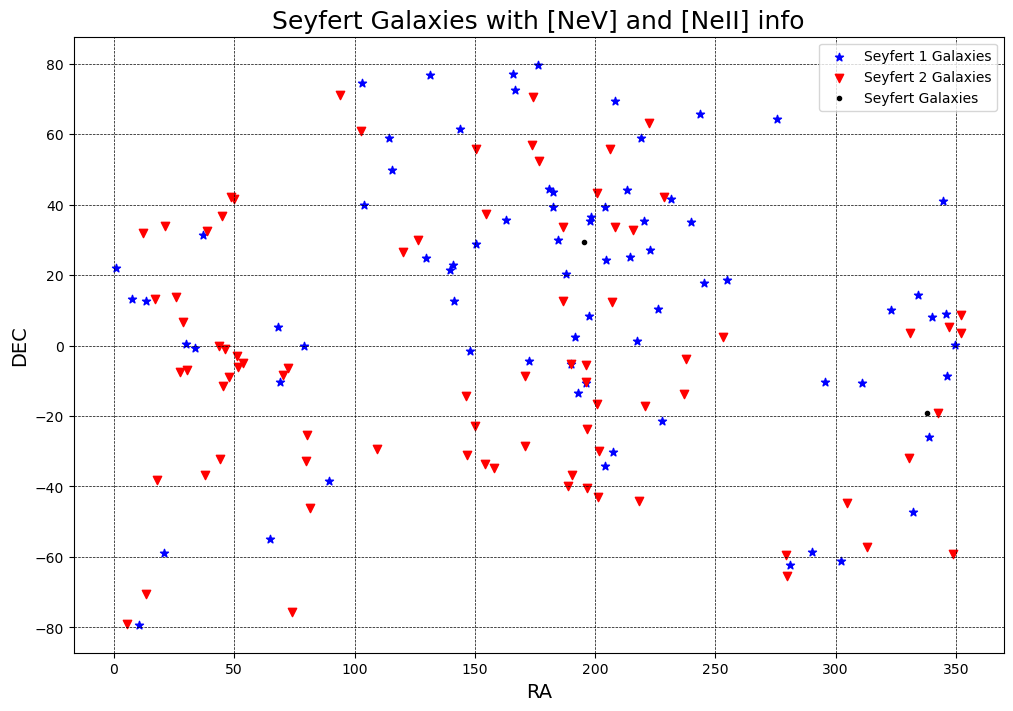

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(Sy1['RA'], Sy1['DEC'], color='blue', marker = '*', label='Seyfert 1 Galaxies')
plt.scatter(Sy2['RA'], Sy2['DEC'], color='red', marker = 'v', label='Seyfert 2 Galaxies')
plt.scatter(SyG['RA'], SyG['DEC'], color='black', marker = '.', label='Seyfert Galaxies')
plt.xlabel(r'RA', fontsize=14)
#plt.xscale('log')
plt.ylabel(r'DEC', fontsize=14)
#plt.ylim(0.0,1.0)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title(r'Seyfert Galaxies with [NeV] and [NeII] info', fontsize=18)
plt.legend()
#plt.savefig(path_graphs+'NeIII_NeII_vs_fracAGN_Sy.jpg')
plt.show()

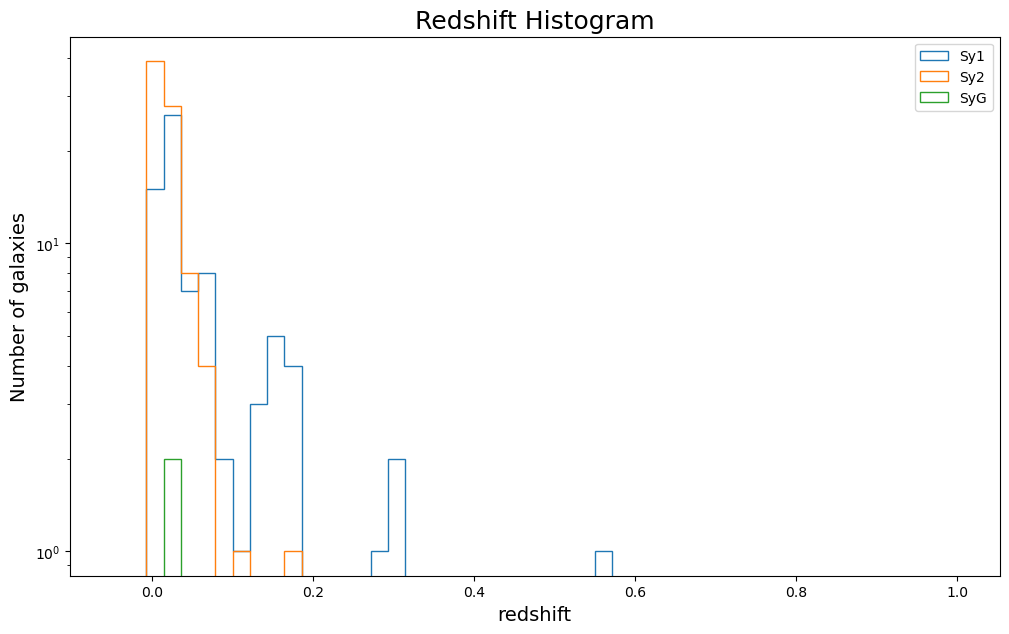

In [30]:
x_Sy1 = Sy1['redshift']
x_Sy2 = Sy2['redshift']
x_SyG = SyG['redshift']
bins_Sy1 = np.linspace(-0.05,1,50)
bins_Sy2 = np.linspace(-0.05,1,50)
bins_SyG = np.linspace(-0.05,1,50)
plt.figure(figsize=(12,7))
plt.hist(x_Sy1, bins=bins_Sy1, histtype='step', label='Sy1')
plt.hist(x_Sy2, bins=bins_Sy2, histtype='step', label='Sy2')
plt.hist(x_SyG, bins=bins_SyG, histtype='step', label='SyG')
plt.xlabel('redshift',fontsize=14)
#plt.xscale('log')
plt.ylabel('Number of galaxies',fontsize=14)
plt.yscale('log')
plt.title('Redshift Histogram', fontsize=18)
plt.legend()

In [31]:
min(Sy2['redshift'])

0.0010546186507665034

In [32]:
max(Sy2['redshift'])

0.173